In [1]:
# Standard library imports
import glob
import os
import shutil
import time

# Third party imports
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.ndimage import generic_filter
from scipy.spatial import distance
import shapefile as shp
from shapely.geometry import Point
import vtk
import pyvista as pv
import pyemu
import pypestutils
import PEST_utils


# Flopy imports
import flopy
import flopy.utils
from flopy.discretization import StructuredGrid
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.mf6.utils.reference import SpatialReference
from flopy.modflow import ModflowNwt, ModflowRch, ModflowStr
from flopy.utils import CellBudgetFile, Raster, ZoneBudget, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.mf6.modflow.mfgwfrcha import ModflowGwfrcha
from flopy.mf6.modflow.mfgwfsfr import ModflowGwfsfr
from flopy.mf6.modflow.mfgwfriv import ModflowGwfriv
from flopy.utils import ZoneBudget6, CellBudgetFile


print("Modules imported successfully.")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


## The following cell deletes the files in the directory. Be careful when using it!

In [2]:
import os
import shutil
import glob

# Specify the directory you want to clean up
directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_master'

# Get a list of all files in the directory
all_files = glob.glob(os.path.join(directory, '*'))

# Specify the file types you want to keep
keep_patterns = ['*.py', '*.ipynb', '*.exe']

# Get a list of files to keep
keep_files = []
for pattern in keep_patterns:
    keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# Specify the directories to skip
skip_directories = ['__pycache__']

# Get a list of files to delete
delete_files = set(all_files) - set(keep_files)

# Delete the files
for file in delete_files:
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue

    if os.path.isfile(file):
        os.remove(file)
    elif os.path.isdir(file):
        shutil.rmtree(file)

# Specify the source directory
source_directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS'

# Copy all files from the source directory to the target directory
for file in glob.glob(os.path.join(source_directory, '*')):
    # Skip the file if it's in the directories to skip
    if any(skip_dir in file for skip_dir in skip_directories):
        continue
    shutil.copy(file, directory)

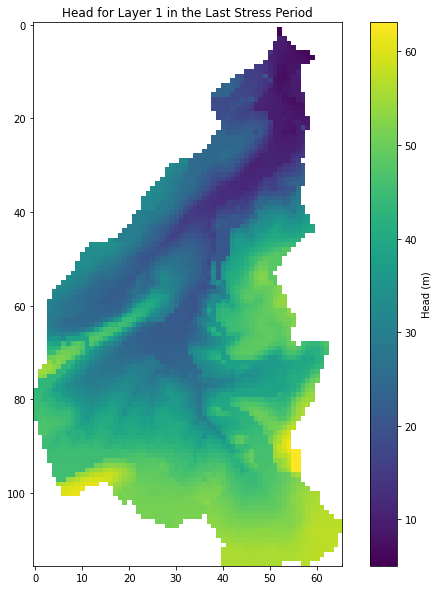

In [2]:

# Load the head data
hds = flopy.utils.HeadFile('Gondebeek_SS.hds')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values lower than -900
head = np.ma.masked_where(head > 50000, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

hds.close()

The number of rows is 32
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...


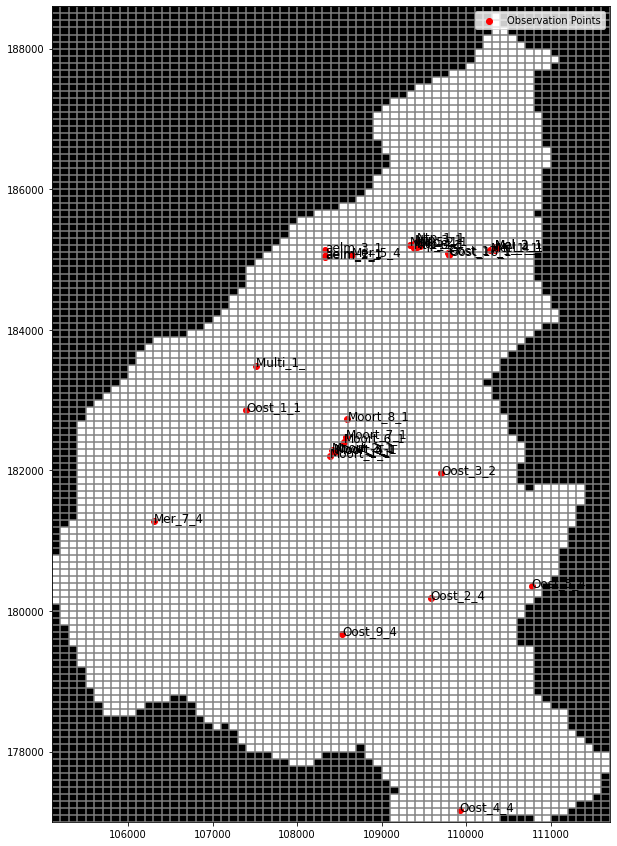

In [3]:
# Load the data
data_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Obs\Standarized_data_in_catchment.csv"
model_path= r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Gondebeek_SS" 
df = pd.read_csv(data_path)

# Drop the rows where 'Layer' is empty
df = df.dropna(subset=['Layer'])

num_rows = df.shape[0]
print(f'The number of rows is {num_rows}')

# Load the MODFLOW 6 model
model = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')

# Get the groundwater flow model from the simulation
gwf = model.get_model('Gondebeek_SS')

# Get the model's discretization package
dis = gwf.dis

# Scatter plot of observation points
fig, ax = plt.subplots(figsize=(10, 15))
modelmap = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
grid = modelmap.plot_grid()
ibound = modelmap.plot_ibound()
scatter = ax.scatter(df['X'], df['Y'], color='red', label='Observation Points')

# Annotate each point with its "Name" and "Layer" attributes
for i in range(df.shape[0]):
    name = df['ID'].iloc[i]
    layer = df['Layer'].iloc[i]
    ax.annotate(f'{name}_{layer}', (df['X'].iloc[i], df['Y'].iloc[i]), fontsize=12)  # Adjust fontsize as needed

# Show the plot
plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


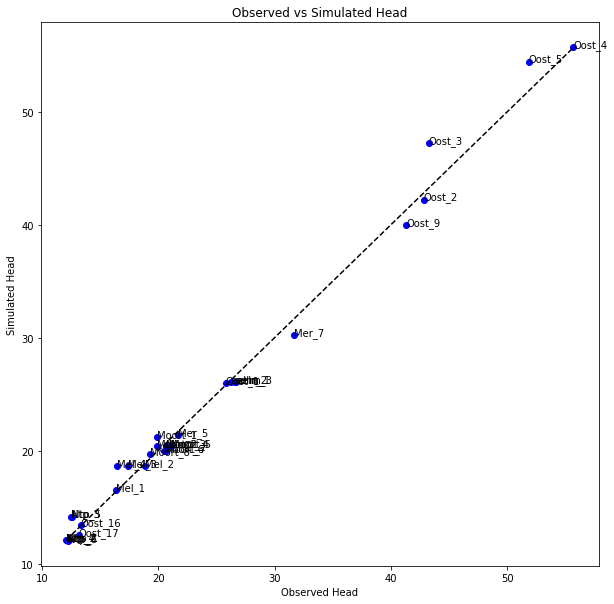

In [4]:
# Load the head data
headfile = flopy.utils.HeadFile('Gondebeek_SS.hds')
head = headfile.get_data(totim=headfile.get_times()[-1])  # Get the head data for the last SP

# Create a function to get the head value at a specific location
def get_head_at_location(x, y, layer):
    try:
        layer = int(layer) - 1  # Subtract 1 from layer
        row, col = gwf.modelgrid.intersect(x, y)  # Convert x, y to row, col
        return head[layer, int(row), int(col)]
    except ValueError:  # If layer can't be converted to an integer
        return np.nan  # Return a default value

# Apply the function to the observation points
df['Simulated_Head'] = df.apply(lambda row: get_head_at_location(row['X'], row['Y'], row['Layer']), axis=1)

# Create a scatter plot of the observed and simulated head values
plt.figure(figsize=(10, 10))
plt.scatter(df['Mean_phrea'], df['Simulated_Head'], color='blue')

# Add labels to the points
for i, point in df.iterrows():
    plt.text(point['Mean_phrea'], point['Simulated_Head'], str(point['ID']))

plt.xlabel('Observed Head')
plt.ylabel('Simulated Head')
plt.title('Observed vs Simulated Head')

# Add a line representing Y=X
plt.plot([df['Mean_phrea'].min(), df['Mean_phrea'].max()], [df['Mean_phrea'].min(), df['Mean_phrea'].max()], 'k--')

plt.show()
hds.close()

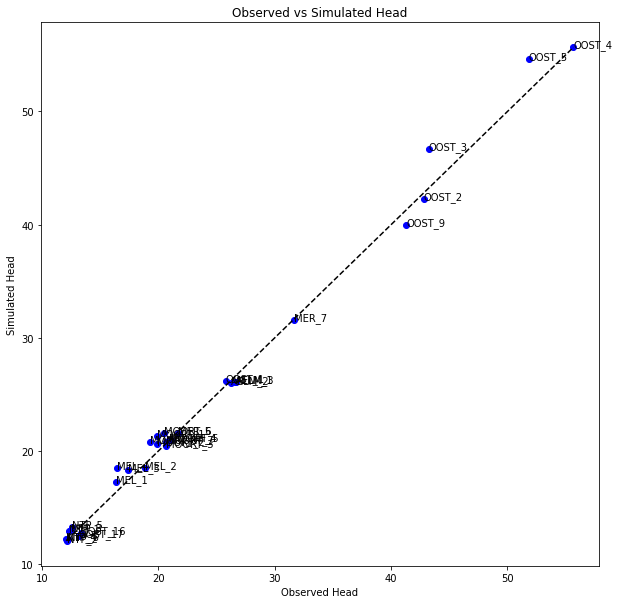

In [5]:
# Load the simulated data
simulated = pd.read_csv('simulated.smp', delim_whitespace=True, header=None, names=['ID', 'Date', 'Hour', 'Value'])

# Convert the 'ID' values in 'df' to uppercase
df['ID'] = df['ID'].str.upper()

# Merge the dataframes
df_merged = pd.merge(df, simulated, on='ID')

# Create a scatter plot of the observed and simulated head values
plt.figure(figsize=(10, 10))
plt.scatter(df_merged['Mean_phrea'], df_merged['Value'], color='blue')

# Add labels to the points
for i, point in df_merged.iterrows():
    plt.text(point['Mean_phrea'], point['Value'], str(point['ID']))

plt.xlabel('Observed Head')
plt.ylabel('Simulated Head')
plt.title('Observed vs Simulated Head')

# Add a line representing Y=X
plt.plot([df_merged['Mean_phrea'].min(), df_merged['Mean_phrea'].max()], [df_merged['Mean_phrea'].min(), df_merged['Mean_phrea'].max()], 'k--')

plt.show()

In [6]:
# Get the hydraulic conductivity array
k = gwf.npf.k.array

# Create a function to get the K value at a specific location
def get_k_at_location(x, y, layer):
    try:
        layer = int(layer) - 1  # Subtract 1 from layer
        row, col = gwf.modelgrid.intersect(x, y)  # Convert x, y to row, col
        return k[layer, int(row), int(col)]
    except ValueError:  # If layer can't be converted to an integer
        return np.nan  # Return a default value

# Create a new DataFrame with the observation points and the K values
df_k = df[['ID', 'X', 'Y', 'Layer']].copy()
df_k['K'] = df.apply(lambda row: get_k_at_location(row['X'], row['Y'], row['Layer']), axis=1)

# Filter out rows where 'Layer' cannot be converted to an integer
df_k = df_k[df_k['K'].notna()]

df_k.head()

,ID,X,Y,Layer,K
0,AELM_1,108334.1,185049.1,1,0.001
1,AELM_2,108334.0,185038.0,1,0.001
2,AELM_3,108334.8,185134.7,1,0.001
5,MEL_1,110287.0,185136.0,1,0.001
6,MEL_2,110344.0,185170.0,1,0.001


In [7]:
# Filter out rows where 'Layer' cannot be converted to an integer
df_filtered = df[pd.to_numeric(df['Layer'], errors='coerce').notna()]


# Save the 'ID', 'X', 'Y', and 'Layer' columns to a text file
df_filtered[['ID', 'X', 'Y', 'Layer']].to_csv('bore_coord.dat', sep='\t', header=False, index=False)



In [8]:
# Convert the 'ID' column to uppercase
df['ID'] = df['ID'].str.upper()

# Create a new DataFrame with the desired format
df_final = pd.DataFrame({
    'ID': df['ID'],
    'date': '01/01/2015',
    'time': '00:00:00',
    'Mean_phrea': df['Mean_phrea']
})

# Save the DataFrame to a text file with tab-separated values without the index
df_final.to_csv('observed.smp', sep='\t', index=False, header=False)

df_final.head()

,ID,date,time,Mean_phrea
0,AELM_1,01/01/2015,00:00:00,26.57
1,AELM_2,01/01/2015,00:00:00,26.29
2,AELM_3,01/01/2015,00:00:00,26.72
5,MEL_1,01/01/2015,00:00:00,16.42
6,MEL_2,01/01/2015,00:00:00,18.91


In [9]:


# Get the number of layers
nlay = gwf.modelgrid.nlay

# Create an empty 3D array for the zones
zones = np.zeros((nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=int)

# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

zone_counter = 1
for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    for k_value in unique_k_values:
        zones[layer][k[layer] == k_value] = zone_counter
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        zone_counter += 1

    # Save the zones for the current layer to a text file
    np.savetxt('zones_layer{}.txt'.format(layer+1), zones[layer], fmt='%d')
    
    


Load the model and write it as external files

In [47]:

# Load the MODFLOW 6 model
model = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS')

model.set_all_data_external()
# Get the hydraulic conductivity array from the NPF package


# Save the hydraulic conductivity arrays to external files
k_filenames = ["k_layer{}.txt".format(i+1) for i in range(k.shape[0])]
for layer in range(k.shape[0]):
    np.savetxt(k_filenames[layer], k[layer])

# Remove the existing NPF package
gwf.remove_package('npf')

# Create a new NPF package that references the external K files
npf = flopy.mf6.ModflowGwfnpf(gwf, k=k_filenames)

npf.write(ext_file_action=k_filenames)

model.write_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package gondebeek_ss...
  writing model gondebeek_ss...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package riv...
    writing package drn...


Create TPL files for K. Only for the zones inside the IBOUND.

In [48]:
# ################################## OLD ONE WITHOUT ZONIFICATION ############################################
# # Get the number of layers
# nlay = gwf.modelgrid.nlay

# # Initialize a dictionary to store the K values for each zone
# zone_k_values = {}

# # Initialize a list to store the data for the DataFrame
# data = []

# idomain = gwf.dis.idomain.array
# zone_counter = 1
# tpl_files = []  # List to store the template file names
# for layer in range(k.shape[0]):
#     unique_k_values = np.unique(k[layer])
#     for k_value in unique_k_values:
#         zones[layer][k[layer] == k_value] = zone_counter
#         zone_k_values[zone_counter] = k_value  # Store the K value for the zone
#         data.append([layer+1, zone_counter, k_value])  # Add the data to the list
#         zone_counter += 1

#     # Create a template file for the current layer
#     tpl_filename = 'zones_layer{}.tpl'.format(layer+1)
#     tpl_files.append(tpl_filename)  # Add the file name to the list
#     with open(tpl_filename, 'w') as f:
#         f.write("ptf ~\n")
#         for row in range(zones[layer].shape[0]):
#             for col in range(zones[layer].shape[1]):
#                 if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
#                     f.write("~{:>10}~ ".format('k'+str(zones[layer][row][col])))  # Write the parameter name
#                 else:  # If the cell is outside the IDOMAIN
#                     f.write("{:>15} ".format("1.00000000E+00"))  # Write the K value
#             f.write("\n")

# # Print the list of template file names
# print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl']


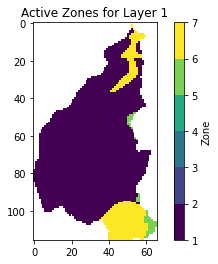

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl']


In [49]:
# Get the number of layers
nlay = gwf.modelgrid.nlay

# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

# Initialize a list to store the data for the DataFrame
data = []

idomain = gwf.dis.idomain.array
zone_counter = 1
tpl_files = []  # List to store the template file names

for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    for k_value in unique_k_values:
        if layer == 0 and k_value == 1.0:  # If it's the first layer and the K value is 1.0
            # Apply your zonification logic here
            # For example, divide the layer into three zones based on a sine function
            for row in range(zones[layer].shape[0]):
                for col in range(zones[layer].shape[1]):
                    if k[layer][row, col] == 1.0:  # If the K value is 1.0
                        # Calculate the y-coordinate of the first curve
                        curve1 = 0.1*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 1.2*zones[layer].shape[0] / 3
                        # Calculate the y-coordinate of the second curve
                        curve2 = 0.3*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 2.75 * zones[layer].shape[0] / 3
                        # Assign the zone based on the y-coordinate of the cell
                        if row < curve1:
                            zones[layer][row, col] = zone_counter
                        elif row < curve2:
                            zones[layer][row, col] = zone_counter + 1
                        else:
                            zones[layer][row, col] = zone_counter + 2
            zone_k_values[zone_counter] = k_value  # Store the K value for the zone
            zone_k_values[zone_counter + 1] = k_value  # Store the K value for the zone
            zone_k_values[zone_counter + 2] = k_value  # Store the K value for the zone
            zone_counter += 3
        else:
            zones[layer][k[layer] == k_value] = zone_counter
            zone_k_values[zone_counter] = k_value  # Store the K value for the zone
            zone_counter += 1
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        data.append([layer+1, zone_counter, k_value])  # Add the data to the list

    # Create a template file for the current layer
    tpl_filename = 'zones_layer{}.tpl'.format(layer+1)
    tpl_files.append(tpl_filename)  # Add the file name to the list
    with open(tpl_filename, 'w') as f:
        f.write("ptf ~\n")
        for row in range(zones[layer].shape[0]):
            for col in range(zones[layer].shape[1]):
                if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
                    f.write("~{:>10}~ ".format('k'+str(zones[layer][row][col])))  # Write the parameter name
                else:  # If the cell is outside the IDOMAIN
                    f.write("{:>15} ".format("1.00000000E+00"))  # Write the K value
            f.write("\n")


import matplotlib.colors as colors
import matplotlib.ticker as ticker

# After all the processing, mask the zones with the idomain
zones_masked = np.ma.masked_where(idomain[0] == 0, zones[0])

# Create a discrete colorbar
bounds = np.linspace(np.min(zones_masked), np.max(zones_masked), np.max(zones_masked) - np.min(zones_masked) + 1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Plot the masked zones for layer 1
fig, ax = plt.subplots()
img = ax.imshow(zones_masked, cmap='viridis', interpolation='none', norm=norm)

# Create a colorbar
cbar = fig.colorbar(img, ax=ax, ticks=ticker.MaxNLocator(integer=True))
cbar.set_label('Zone')

plt.title('Active Zones for Layer 1')
plt.show()
# Print the list of template file names
print(tpl_files)

In [50]:
print(zone_k_values)

for zone, k_value in zone_k_values.items():
    print(f'Zone {zone}: K value = {k_value}')

{1: 0.001, 2: 1.0, 3: 1.0, 4: 1.0, 5: 4.756946, 6: 7.156774, 7: 17.83345, 8: 0.0010000002, 9: 1.0, 10: 3.520326, 11: 11.87731, 12: 0.001, 13: 0.093563537, 14: 1.0, 15: 6.656236, 16: 9.554184, 17: 0.001, 18: 0.0010000123, 19: 1.0, 20: 1.907585, 21: 2.926829, 22: 2.926829}
Zone 1: K value = 0.001
Zone 2: K value = 1.0
Zone 3: K value = 1.0
Zone 4: K value = 1.0
Zone 5: K value = 4.756946
Zone 6: K value = 7.156774
Zone 7: K value = 17.83345
Zone 8: K value = 0.0010000002
Zone 9: K value = 1.0
Zone 10: K value = 3.520326
Zone 11: K value = 11.87731
Zone 12: K value = 0.001
Zone 13: K value = 0.093563537
Zone 14: K value = 1.0
Zone 15: K value = 6.656236
Zone 16: K value = 9.554184
Zone 17: K value = 0.001
Zone 18: K value = 0.0010000123
Zone 19: K value = 1.0
Zone 20: K value = 1.907585
Zone 21: K value = 2.926829
Zone 22: K value = 2.926829


Create TPL file for the River package (conductance)

In [51]:
def create_tpl_file(original_file, tpl_file,replacetxt,):
    # Read the original file
    with open(original_file, 'r') as f:
        lines = f.readlines()

    # Modify the fifth column and write to the template file
    with open(tpl_file, 'w') as f:
        f.write("ptf ~\n")  # Write the parameter transformation flag
        for line in lines:
            parts = line.split()
            parts[4] = replacetxt  # Replace the fifth column
            f.write(' '.join(parts) + '\n')

    # Add the template file to the list
    tpl_files.append(tpl_file)

# Use the function to create the template file
create_tpl_file('Gondebeek_SS.riv_stress_period_data_1.txt', 'riv.tpl',"~        c~")

print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'riv.tpl']


Create TPL for drain package (conductance)

In [52]:
# Use the function to create the template file
create_tpl_file('Gondebeek_SS.drn_stress_period_data_1.txt', 'drn.tpl',"~        c2~")

print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'riv.tpl', 'drn.tpl']


Create INS file for the observation.smp

In [17]:
# Read the 'simulated.smp' file
df2 = pd.read_csv('simulated.smp', sep='\s+', header=None)

# Extract the observation IDs and values
obs_ids = df2[0].tolist()
values = df2[3].tolist()

# Open the TPL file
with open('simulated.smp.tpl', 'w') as f:
    # Write the PIF line
    f.write('pif ~\n')

    # Write the observation IDs and values
    for obs_id, value in zip(obs_ids, values):
        f.write('l1   [HEAD_{}]55:66\n'.format(obs_id))

print("TPL file 'simulated.smp.tpl' created.")

TPL file 'simulated.smp.tpl' created.


<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\sebas\AppData\Local\Temp/ipykernel_25936/94460371.py:2: DeprecationWarning: invalid escape sequence \s


In [18]:
gwf.dis.nlay.data

4

Creation of neccesary PEST files with PEST_utils (do not run every time!!)

In [19]:
#instruction file for mf6mod2obs
#instruction_file = PEST_utils.mf6mod2obs_in(os.getcwd(), 'file.ntb','observed.smp' , 'Gondebeek_SS.hds', 's', gwf.dis.nlay.data, 'd', '01-01-2015', 10, 'simulated.smp')


# Delete the 'run_model.bat' file if it exists
if os.path.exists('run_model.bat'):
    os.remove('run_model.bat')

# Use the function to add instructions to the batch file
PEST_utils.addbatchfile(os.getcwd(), '@echo off', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.hds', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.cbc', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6.exe Gondebeek_SS.nam', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6mod2obs < simulated.in', 'run_model.bat')

pst=PEST_utils.pestprep1(os.getcwd(),'gondebeek_ss_drn.pst', 'observed.smp', 'simulated.smp','prefix','head', tpl_files, 'run_model.bat')

From this line now on are the results

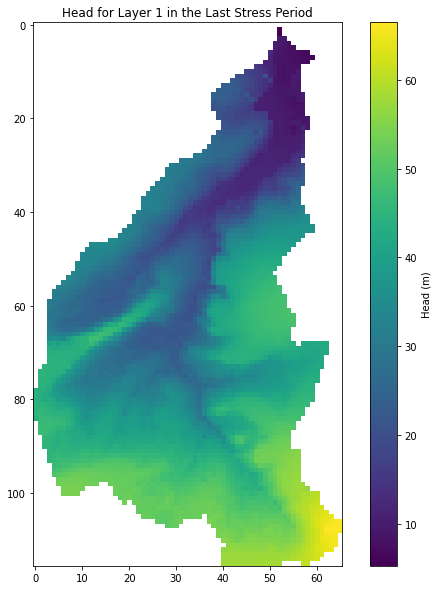

In [10]:
result_ws='C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS_it8'

# Load the head data
hds = flopy.utils.HeadFile(os.path.join(result_ws,'Gondebeek_SS.hds'))

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values greater than 200
head = np.ma.masked_where(head > 1e29, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()
hds.close()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...


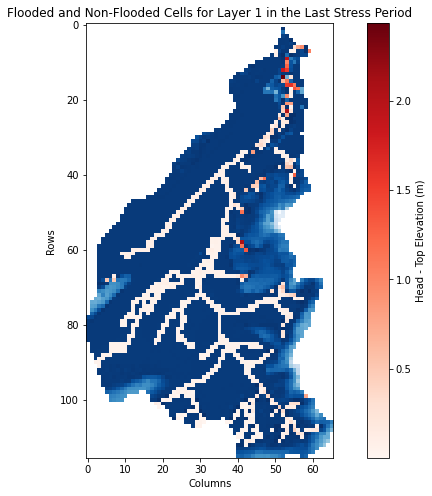

In [11]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS', sim_ws=result_ws)  # Replace 'Gondebeek_SS.nam' with your model name
gwf = sim.get_model('Gondebeek_SS')

# Get the top elevation of the cells
top = gwf.dis.top.array

# Calculate the difference between the head and the top elevation
diff = head[1, :, :] - top

# Create a mask for the flooded cells (where the difference is positive)
flooded = np.ma.masked_where(diff <= 0, diff)

# Create a mask for the non-flooded cells (where the difference is zero or negative)
non_flooded = np.ma.masked_where(diff > 0, diff)

# Create a subplot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size if needed

# Plot the non-flooded cells in blue and the flooded cells in red
im_nf = ax.imshow(non_flooded, cmap='Blues', interpolation='none')
im_f = ax.imshow(flooded, cmap='Reds', interpolation='none')

# Add a colorbar to the subplot
cbar = fig.colorbar(im_f, ax=ax, label='Head - Top Elevation (m)')

ax.set_title('Flooded and Non-Flooded Cells for Layer 1 in the Last Stress Period')
ax.set_xlabel('Columns')  # Add your X-axis label here
ax.set_ylabel('Rows')  # Add your Y-axis label here


# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_flooded_cells.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename, bbox_inches='tight', dpi=300)

# Show the figure (optional)
plt.show()

# Show the figure (optional)
plt.show()

# Close the file (if needed)
hds.close()


NRMSE Pre-PEST: 5.98243939326227%
NRMSE PEST: 3.171024496534896%


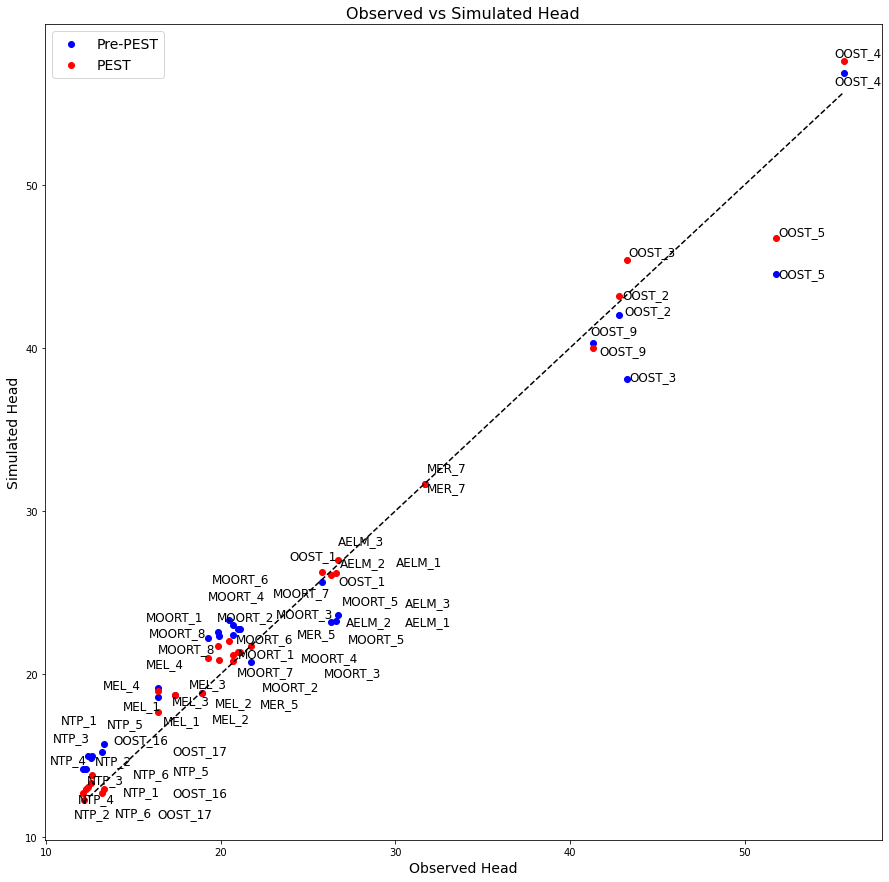

In [12]:
from adjustText import adjust_text
from sklearn.metrics import mean_squared_error
from math import sqrt

# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "it3"
filename = f"{folder_name}"
# Load the simulated data
simulated1 = pd.read_csv('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_SS/simulated.smp', delim_whitespace=True, header=None, names=['ID', 'Date', 'Hour', 'Value'])
simulated2 = pd.read_csv(os.path.join(result_ws,'simulated.smp'), delim_whitespace=True, header=None, names=['ID', 'Date', 'Hour', 'Value'])

# Convert the 'ID' values in 'df' to uppercase
df['ID'] = df['ID'].str.upper()

# Merge the dataframes
df_merged1 = pd.merge(df, simulated1, on='ID')
df_merged2 = pd.merge(df, simulated2, on='ID')

# Compute the NRMSE
nrmse1 = sqrt(mean_squared_error(df_merged1['Mean_phrea'], df_merged1['Value'])) / (df_merged1['Mean_phrea'].max() - df_merged1['Mean_phrea'].min())
nrmse2 = sqrt(mean_squared_error(df_merged2['Mean_phrea'], df_merged2['Value'])) / (df_merged2['Mean_phrea'].max() - df_merged2['Mean_phrea'].min())

print(f'NRMSE Pre-PEST: {nrmse1*100}%')
print(f'NRMSE PEST: {nrmse2*100}%')

# Create a scatter plot of the observed and simulated head values
plt.figure(figsize=(15, 15))
plt.scatter(df_merged1['Mean_phrea'], df_merged1['Value'], color='blue', label='Pre-PEST')
plt.scatter(df_merged2['Mean_phrea'], df_merged2['Value'], color='red', label='PEST')

# Add labels to the points
texts = []
for i, point in df_merged1.iterrows():
    texts.append(plt.text(point['Mean_phrea'], point['Value'], str(point['ID']), fontsize=12))
for i, point in df_merged2.iterrows():
    texts.append(plt.text(point['Mean_phrea'], point['Value'], str(point['ID']), fontsize=12))

adjust_text(texts)

plt.xlabel('Observed Head', fontsize=14)
plt.ylabel('Simulated Head', fontsize=14)
plt.title('Observed vs Simulated Head', fontsize=16)

# Add a line representing Y=X
plt.plot([df['Mean_phrea'].min(), df['Mean_phrea'].max()], [df['Mean_phrea'].min(), df['Mean_phrea'].max()], 'k--')

plt.legend(fontsize=14)

# Save the figure
plt.savefig(filename, dpi=300)
plt.show()

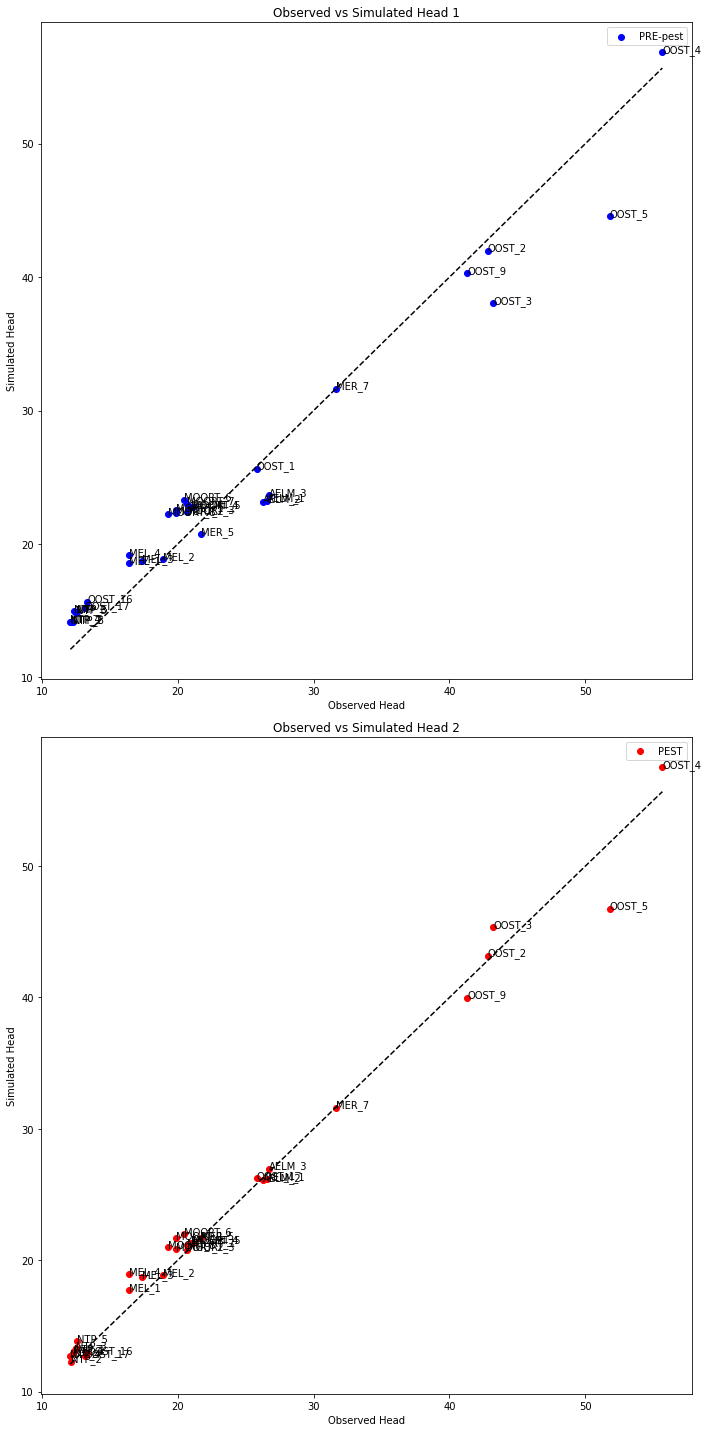

In [13]:
fig, axs = plt.subplots(2, figsize=(10, 20))

# Plot for Simulated 1
axs[0].scatter(df_merged1['Mean_phrea'], df_merged1['Value'], color='blue', label='PRE-pest')
for i, point in df_merged1.iterrows():
    axs[0].text(point['Mean_phrea'], point['Value'], str(point['ID']))
axs[0].plot([df['Mean_phrea'].min(), df['Mean_phrea'].max()], [df['Mean_phrea'].min(), df['Mean_phrea'].max()], 'k--')
axs[0].set_xlabel('Observed Head')
axs[0].set_ylabel('Simulated Head')
axs[0].set_title('Observed vs Simulated Head 1')
axs[0].legend()

# Plot for Simulated 2
axs[1].scatter(df_merged2['Mean_phrea'], df_merged2['Value'], color='red', label='PEST')
for i, point in df_merged2.iterrows():
    axs[1].text(point['Mean_phrea'], point['Value'], str(point['ID']))
axs[1].plot([df['Mean_phrea'].min(), df['Mean_phrea'].max()], [df['Mean_phrea'].min(), df['Mean_phrea'].max()], 'k--')
axs[1].set_xlabel('Observed Head')
axs[1].set_ylabel('Simulated Head')
axs[1].set_title('Observed vs Simulated Head 2')
axs[1].legend()

plt.tight_layout()
plt.show()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...


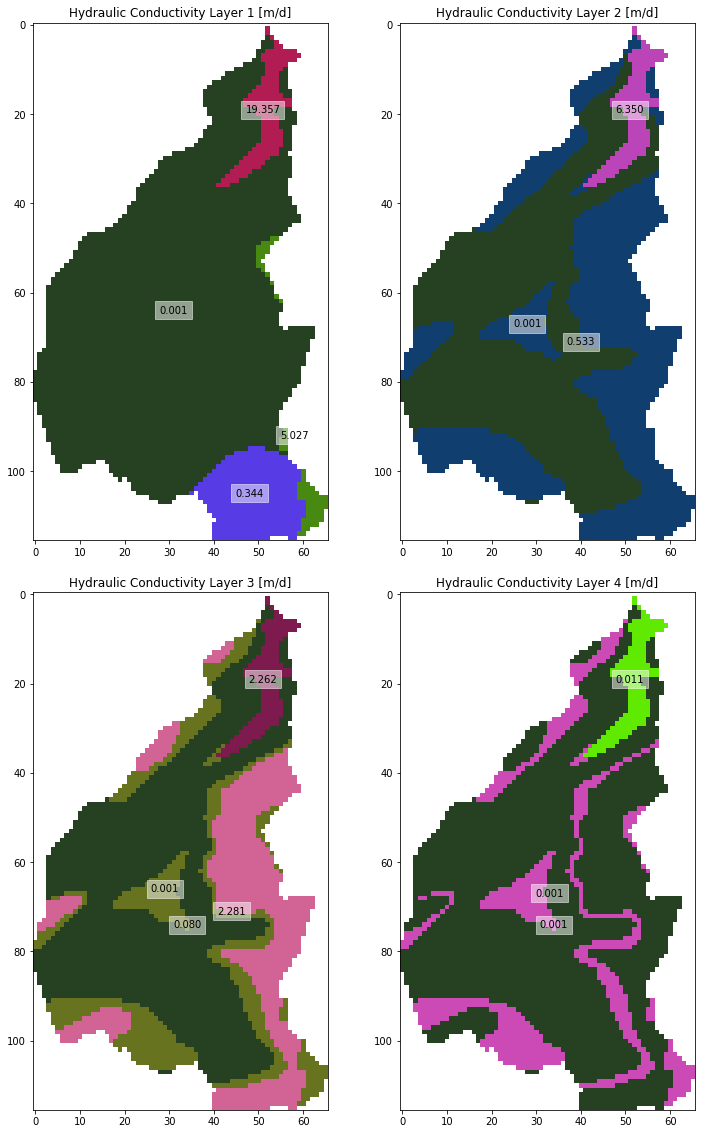

In [14]:
import matplotlib.colors as mcolors
import numpy as np
import random

# Define the workspace and model name
model_ws = result_ws
model_name = 'Gondebeek_SS'

# Create a simulation
sim = flopy.mf6.MFSimulation.load(sim_name=model_name, exe_name='mf6', sim_ws=model_ws)

# Get the groundwater flow model
gwf = sim.get_model(model_name)

# Get the hydraulic conductivity values
hk = gwf.npf.k.array

# Get the idomain values
idomain = gwf.dis.idomain.array

# Mask the hydraulic conductivity values with the idomain
hk_masked = np.ma.masked_where(idomain == 0, hk)

# Get unique hydraulic conductivity values and assign each a unique random color
unique_hk = np.unique(hk_masked.compressed())  # Use the compressed() method to remove the MaskedConstant values
colors = [np.random.rand(3,) for _ in range(len(unique_hk))]
hk_color_dict = dict(zip(unique_hk, colors))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Plot the hydraulic conductivity of each layer
for i, layer in enumerate(hk_masked):
    ax = axs[i//2, i%2]  # Select the current subplot
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))  # Initialize the color_layer array with ones
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                color_layer[j, k] = hk_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    
    ax.set_title(f'Hydraulic Conductivity Layer {i+1} [m/d]')
    
    # Create a dictionary where each unique hydraulic conductivity value is a key and the corresponding value is a list of coordinates where this hydraulic conductivity value occurs
    hk_coords = {hk: [] for hk in unique_hk}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                hk_coords[layer[j, k]].append((j, k))
    
    # For each unique hydraulic conductivity value, calculate the center of the corresponding coordinates and display the hydraulic conductivity value at this center
    for hk, coords in hk_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{hk:.3f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use three significant digits

# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_HK_layers.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename)

# Show the figure (optional)
plt.show()

Same as above but with obs points

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...


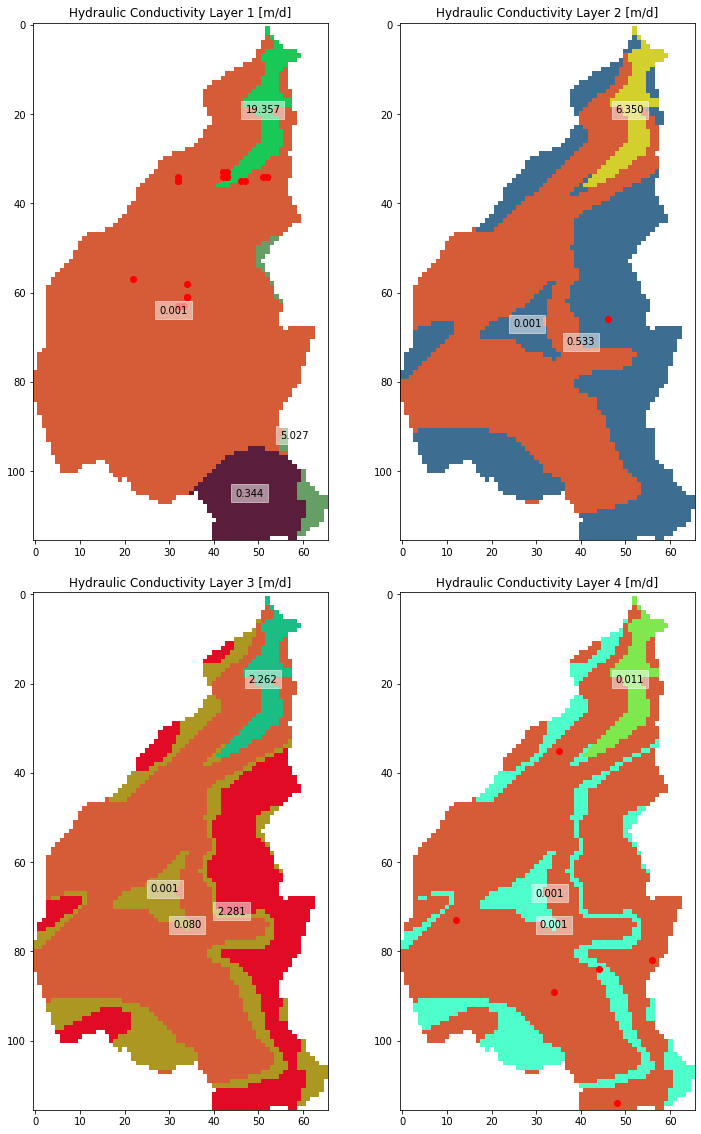

In [15]:
import matplotlib.colors as mcolors
import numpy as np
import random
import pandas as pd

# Define the workspace and model name
model_ws = result_ws
model_name = 'Gondebeek_SS'

# Create a simulation
sim = flopy.mf6.MFSimulation.load(sim_name=model_name, exe_name='mf6', sim_ws=model_ws)

# Get the groundwater flow model
gwf = sim.get_model(model_name)

# Get the hydraulic conductivity values
hk = gwf.npf.k.array

# Get the idomain values
idomain = gwf.dis.idomain.array

# Mask the hydraulic conductivity values with the idomain
hk_masked = np.ma.masked_where(idomain == 0, hk)

# Get unique hydraulic conductivity values and assign each a unique random color
unique_hk = np.unique(hk_masked.compressed())  # Use the compressed() method to remove the MaskedConstant values
colors = [np.random.rand(3,) for _ in range(len(unique_hk))]
hk_color_dict = dict(zip(unique_hk, colors))

# Read the observation points
obs_points = pd.read_csv(model_ws + '/bore_coord.dat', sep='\t', header=None, names=['name', 'x', 'y', 'layer'])

# Convert the x and y coordinates to row and column indices
obs_points['row'] = np.floor((gwf.modelgrid.extent[3] - obs_points['y']) / gwf.modelgrid.delc[0]).astype(int)
obs_points['col'] = np.floor((obs_points['x'] - gwf.modelgrid.extent[0]) / gwf.modelgrid.delr[0]).astype(int)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Plot the hydraulic conductivity of each layer
for i, layer in enumerate(hk_masked):
    ax = axs[i//2, i%2]  # Select the current subplot
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))  # Initialize the color_layer array with ones
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                color_layer[j, k] = hk_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    
    ax.set_title(f'Hydraulic Conductivity Layer {i+1} [m/d]')
    
    # Create a dictionary where each unique hydraulic conductivity value is a key and the corresponding value is a list of coordinates where this hydraulic conductivity value occurs
    hk_coords = {hk: [] for hk in unique_hk}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                hk_coords[layer[j, k]].append((j, k))
    
    # For each unique hydraulic conductivity value, calculate the center of the corresponding coordinates and display the hydraulic conductivity value at this center
    for hk, coords in hk_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{hk:.3f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use three significant digits

    # Plot the observation points on the current layer
    layer_obs_points = obs_points[obs_points['layer'] == i+1]
    ax.scatter(layer_obs_points['col'], layer_obs_points['row'], color='red')

# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_HK_layers_obs_points.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename)

# Show the figure (optional)
plt.show()

## Budget results

In [16]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek_SS',sim_ws=result_ws)
gwf = sim.get_model('Gondebeek_SS')

# Get the idomain array from the dis package of the model
idomain = gwf.dis.idomain.array

# Create the zone array from the idomain array
zon = np.where(idomain == 0, 1, idomain)

zonbud = gwf.output.zonebudget(zon)
zonbud.change_model_ws(result_ws)
zonbud.write_input()
zonbud.run_model()

df_res = zonbud.get_dataframes(net=True)
df_res = df_res.reset_index()

# Delete the zonbud object


# Print the contents of the CSV file for the last time step and stress period
print(df_res)
print(df_res['name'],df_res['ZONE_1']/86.4)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package gondebeek_ss...
FloPy is using the following executable to run the model: ..\Modflow_SS_master\zbud6.exe
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.4.4 02/13/2024
......
 
Normal Termination
   totim    name        ZONE_1
0    1.0  STO_SS      0.000000
1    1.0     DRN -12683.350656
2    1.0     RIV  -1865.123573
3    1.0    RCHA  14548.318866
4    1.0  ZONE_0      0.000000
5    1.0  ZONE_1      0.000000
0    STO_SS
1       DRN
2       RIV
3      RCHA
4    ZONE_0
5    ZONE_1
Name: name, dtype: object 0      0.000000
1   -146.798040
2    -21.587078
3

Create a mesh with PyVista

In [17]:

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(gwf, modelgrid=sim, vertical_exageration=10,binary=False)

# Flatten the entire 3D array of bottom elevations
botm_flattened = gwf.dis.botm.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(botm_flattened, "botm")

# Calculate the top elevations
botm = gwf.dis.botm.array
top = np.empty_like(botm)
top[0] = gwf.dis.top.array
top[1:] = botm[:-1]

# Flatten the entire 3D array of top elevations
top_flattened = top.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(top_flattened, "top")

# Flatten the entire 3D array of hydraulic conductivity
hk_flattened = gwf.npf.k.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(hk_flattened, "k")

# Flatten the entire 3D array of specific storage
ss_flattened = gwf.sto.ss.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ss_flattened, "ss")

# Flatten the entire 3D array of specific yield
sy_flattened = gwf.sto.sy.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(sy_flattened, "sy")

# Flatten the entire 3D array of ibound
ibound_flattened = gwf.dis.idomain.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ibound_flattened, "ibound")

# Write the VTK object to a file
vtkobj.write("model_SS.vtk")


In [18]:
# Set the backend for PyVista
pv.set_jupyter_backend('trame')

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# List all available point data
print(thresholded_mesh)

# Plot the thresholded mesh with a specific property
# Replace 'property_name' with the name of the property you want to visualize
thresholded_mesh.plot(scalars='k', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_SS_act.vtk")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\trame\ui\__init__.py:1: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame.ui')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\pkg_resources\__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages


UnstructuredGrid (0x1e70a9f83a0)
  N Cells:    17392
  N Points:   139136
  X Bounds:   1.051e+05, 1.117e+05
  Y Bounds:   1.770e+05, 1.885e+05
  Z Bounds:   -2.823e+02, 7.836e+02
  N Arrays:   6


Widget(value='<iframe src="http://localhost:64810/index.html?ui=P_0x1e70a977700_0&reconnect=auto" class="pyvis…